<h1>Forecasting Using Vairous Techniques</h1>

In this notebook we will explore some of the simpler techniques that can be used to forecast the time series data. Following models has been explained in this notebook.

* Naive Approach
* Moving Average
* Simple Exponential Smoothing
* Holt's Linear Trend Model
* Holt's Winter Model

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [48]:
#loading the data that we processed after eda
train = pd.read_csv('data/train.csv', parse_dates=[0], index_col=[0])
train_original = pd.read_csv('data/train_original', parse_dates=['Datetime'], index_col='Datetime')
test_original = pd.read_csv('data/test_original', parse_dates=['Datetime'], index_col='Datetime')

In [18]:
train.tail(5)

,ID,Count,year,month,day,Hour,day_of_week,weekend
Datetime,,,,,,,,
2014-09-21,18179.5,379.250000,2014.0,9.0,21.0,11.5,6.0,1.0
2014-09-22,18203.5,588.166667,2014.0,9.0,22.0,11.5,0.0,0.0
2014-09-23,18227.5,554.333333,2014.0,9.0,23.0,11.5,1.0,0.0
2014-09-24,18251.5,702.333333,2014.0,9.0,24.0,11.5,2.0,0.0
2014-09-25,18275.5,589.666667,2014.0,9.0,25.0,11.5,3.0,0.0


In [19]:
#splitting the data into training and validation part
Train = train.ix['2012-08-25':'2014-06-24']
valid = train.ix['2014-06-25':'2014-09-25']

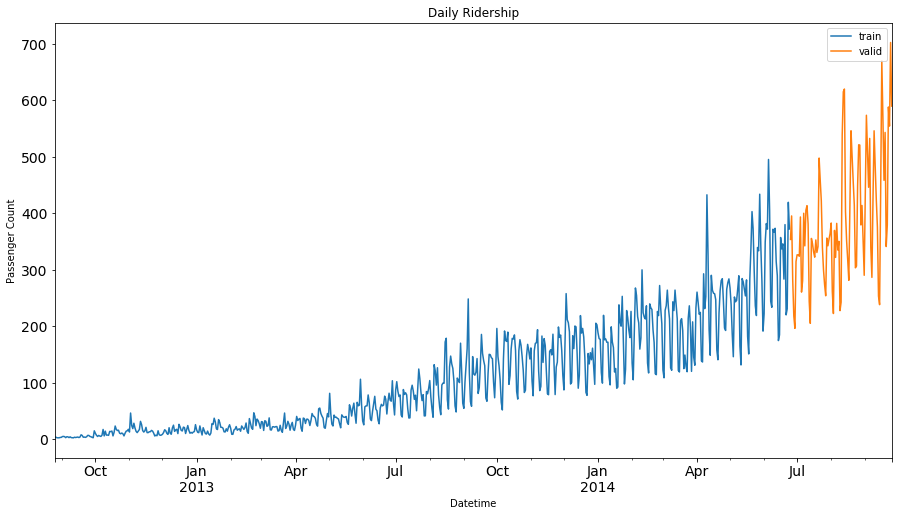

In [20]:
#visualizing the train and validation part
plt.figure(figsize=(15,8))
Train.Count.plot(title='Daily Ridership', fontsize=14, label = 'train')
valid.Count.plot(title='Daily Ridership', fontsize=14, label = 'valid')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.legend(loc = 'best')
plt.show()

### Naive Approach

In this method, we assume that the next expected point is equal to the last observed point.

In [21]:
#making prediction using naive approach
dd = np.asanyarray(Train.Count)
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1]

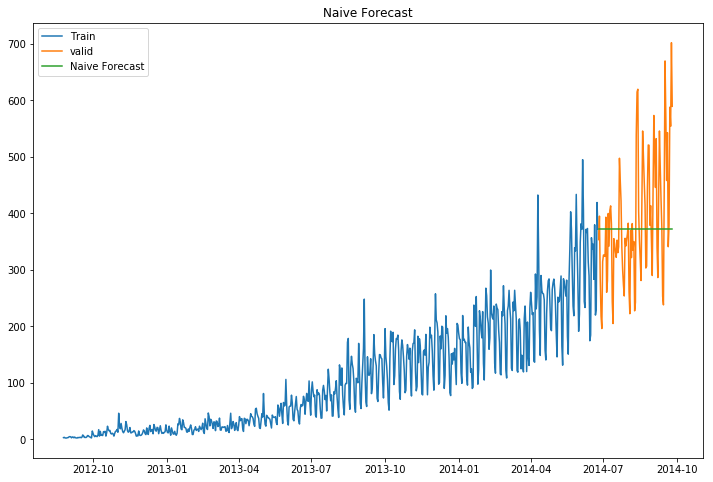

In [22]:
plt.figure(figsize = (12,8))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(valid.index, valid['Count'], label='valid')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc = 'best')
plt.title('Naive Forecast')
plt.show()

In [30]:
from utility import evaluate_model

In [31]:
evaluate_model(valid.Count, y_hat.naive)

Evaluation Metrics:
--------------------
RMS:111.79050467496724
MAPE:0.23291873125021056
MPE:0.04602516504629942
--------------------


### Moving Average

In this method predictions are made on the basis of average of last few points instead of taking all previously known values.
Lets try the rolling mean for last 10, 20 and 50 days and visualize the results.

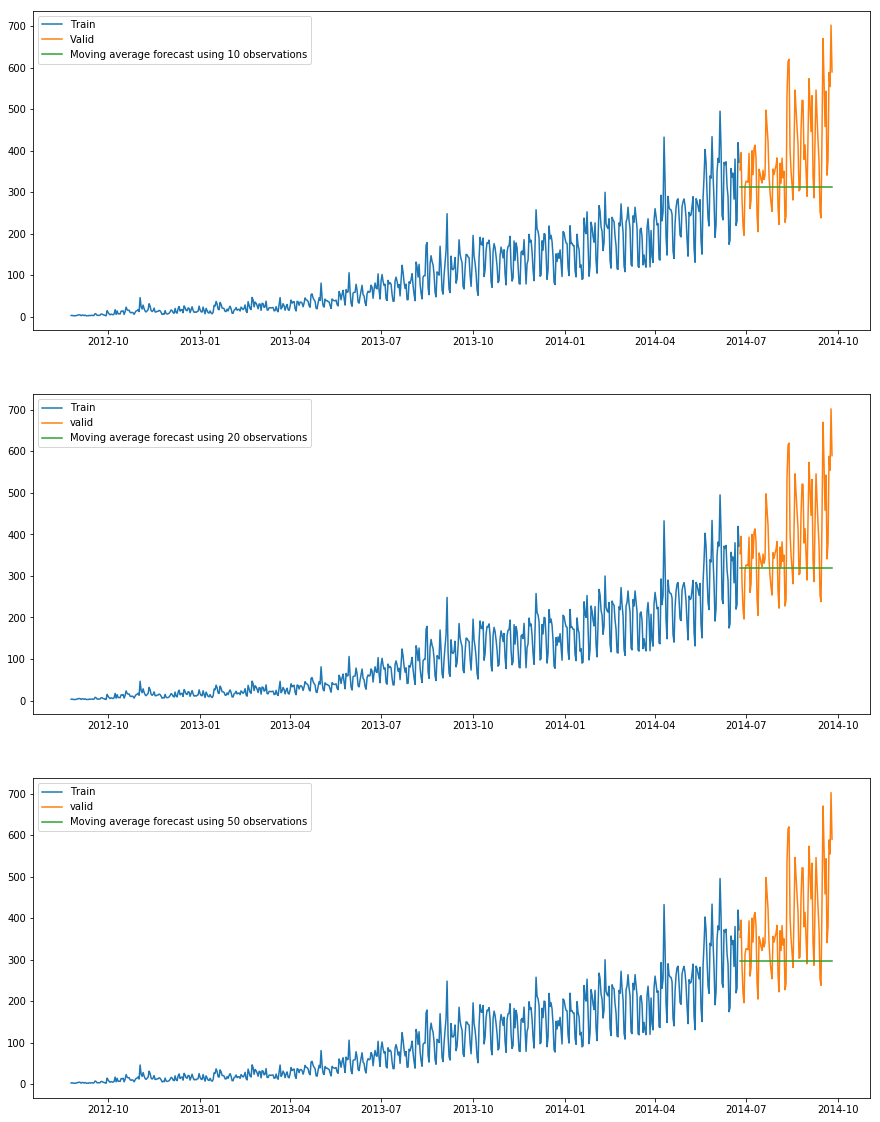

In [32]:
f, ax = plt.subplots(3,1, figsize = (15, 20))

y_hat_avg = valid.copy()
#average of last 10 observations
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1]
ax[0].plot(Train['Count'], label = 'Train')
ax[0].plot(valid['Count'], label = 'Valid')
ax[0].plot(y_hat_avg['moving_avg_forecast'], label = 'Moving average forecast using 10 observations')
ax[0].legend(loc = 'best')

y_hat_avg = valid.copy()
#average of last 20 observations
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1]
ax[1].plot(Train['Count'], label = 'Train')
ax[1].plot(valid['Count'], label = 'valid')
ax[1].plot(y_hat_avg['moving_avg_forecast'], label = 'Moving average forecast using 20 observations')
ax[1].legend(loc = 'best')

y_hat_avg = valid.copy()
#average of last 50 observations
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1]
ax[2].plot(Train['Count'], label = 'Train')
ax[2].plot(valid['Count'], label = 'valid')
ax[2].plot(y_hat_avg['moving_avg_forecast'], label = 'Moving average forecast using 50 observations')
ax[2].legend(loc = 'best')
plt.show()


In [33]:
evaluate_model(valid.Count, y_hat_avg.moving_avg_forecast)

Evaluation Metrics:
--------------------
RMS:144.19175679986802
MAPE:0.37195833097708997
MPE:0.3124096471144357
--------------------


### Simple Exponential Smoothing
* In this technique we assign larger weights to more recent observations than to observations from the distant past.
* The weights decrease exponentially as observations goes further in the past. The smallest weights are associated with the oldest observations.

In [34]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy()

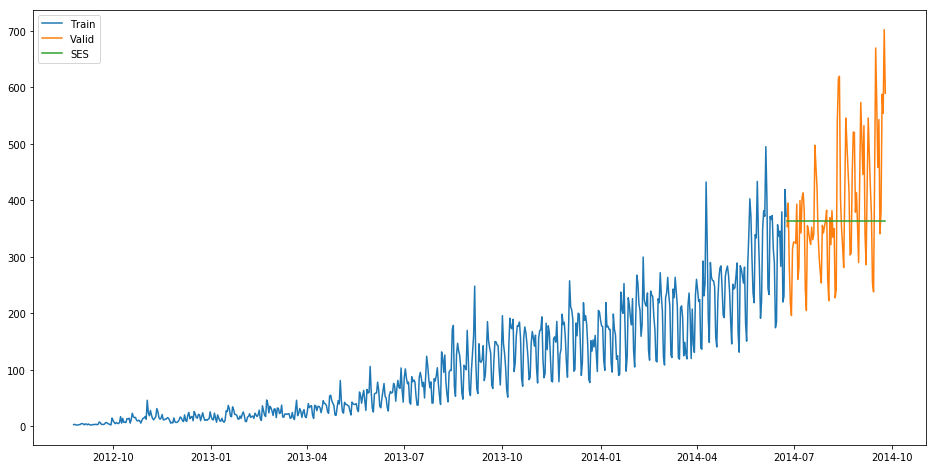

In [35]:
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6, optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['SES'], label = 'SES')
plt.legend(loc = 'best')
plt.show()

In [36]:
evaluate_model(valid.Count, y_hat_avg.SES)

Evaluation Metrics:
--------------------
RMS:113.43708111884511
MAPE:0.23809181364134221
MPE:0.07089852002726395
--------------------


### Holt's Linear Trend Model

* It is an extension of simple exponential smoothing to allow forecasting of the data with a trend.
* This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend

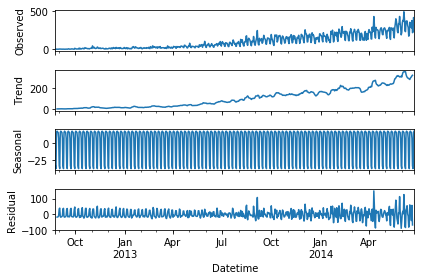

In [37]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train['Count']).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

An Increasing trend can be seen in the datset, so now we will makw a model based on the trend

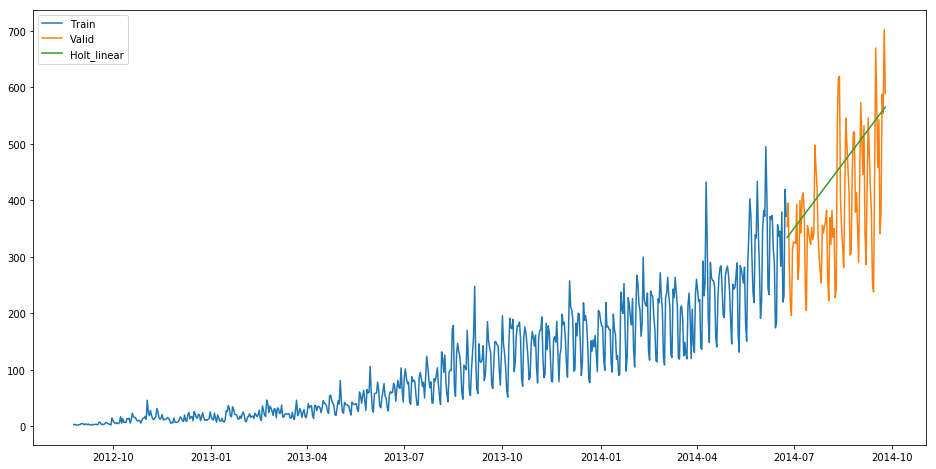

In [38]:
y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3, smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['Holt_linear'], label = 'Holt_linear')
plt.legend(loc='best')
plt.show()

In [39]:
evaluate_model(valid.Count, y_hat_avg.Holt_linear)

Evaluation Metrics:
--------------------
RMS:112.94278345314065
MAPE:0.20133197417049334
MPE:-0.13397406575154208
--------------------


In [41]:
#predicting the test data
pedict = fit1.forecast(len(test))
test['prediction'] = pedict

The prediction we made is daily predictions, we have to convert these predictions to hourly basis.

In [50]:
test_original.head()

,Unnamed: 0,ID,year,month,day,Hour
Datetime,,,,,,
2014-09-26 00:00:00,0,18288,2014,9,26,0
2014-09-26 01:00:00,1,18289,2014,9,26,1
2014-09-26 02:00:00,2,18290,2014,9,26,2
2014-09-26 03:00:00,3,18291,2014,9,26,3
2014-09-26 04:00:00,4,18292,2014,9,26,4


In [51]:
#calculating the hourly ratio of count
train_original['ratio'] = train_original['Count']/train_original['Count'].sum()

#Grouping the hourly ratio
temp = train_original.groupby(['Hour'])['ratio'].sum()

#groupby to csv format
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('Groupby.csv')

temp2 = pd.read_csv('Groupby.csv')
temp2 = temp2.drop('Hour.1',1)

#Merge Test and test_original on day, month and year
merge = pd.merge(test, test_original, on = ('day','month','year'), how='left')
merge['Hour'] = merge['Hour_y']
merge = merge.drop(['year','month','Datetime','Hour_x', 'Hour_y'], axis = 1)

#predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on = 'Hour', how = 'left')

# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24 
prediction['ID']=prediction['ID_y']

In [52]:
submission=prediction.drop(['ID_x', 'day', 'ID_y','prediction','Hour', 'ratio'],axis=1) 
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt linear.csv')

### Holts Winters Model on Daily Time Series
* Holt's Winter Model applies exponential smoothing to the seasonal components in addition to level and trend

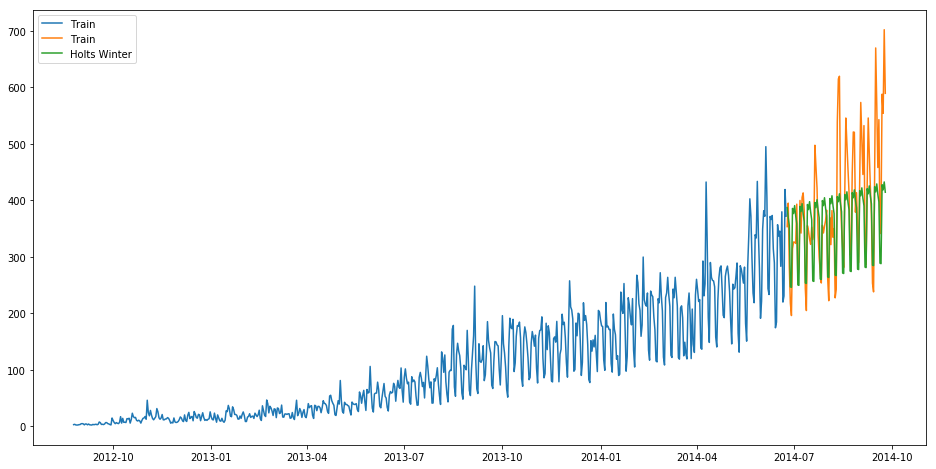

In [40]:
y_hat_avg = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods=7, trend='add', seasonal='add').fit()
y_hat_avg['Holts_Winter'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Train')
plt.plot(y_hat_avg['Holts_Winter'], label = 'Holts Winter')
plt.legend(loc = 'best')
plt.show()

In [54]:
evaluate_model(valid.Count, y_hat_avg.Holts_Winter)

Evaluation Metrics:
--------------------
RMS:82.37573072548413
MAPE:0.1630703267448658
MPE:0.07160984171992536
--------------------


In [53]:
predict = fit1.forecast(len(test))

Now we will convert these daily passenger count to hourly as before

In [55]:
test['prediction'] = predict

#merge test and test_original on day, month and year
merge = pd.merge(test, test_original, on = ('day','month','year'), how = 'left')
merge['Hour'] = merge['Hour_y']
merge=merge.drop(['year','month','Datetime','Hour_x', 'Hour_y'], axis = 1)
prediction = pd.merge(merge, temp2, on = 'Hour', how = 'left')
prediction['Count'] = prediction['prediction']*prediction['ratio']*24

prediction['ID'] = prediction['ID_y']
submission = prediction.drop(['day','Hour','ratio', 'prediction','ID_x','ID_y'], axis = 1)

#converting the final submission to CSV format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holts winters.csv')